In [39]:
#Import Bibliotecas
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#Parameter

#Lebensdauer
lifespan_pv = 20 #Jahre
lifespan_hp = 20 #Jahre
lifespan_battery = 15 #Jahre 
lifespan_heat_store = 25 #Jahre
#Betriebskosten
marginal_cost_pv = 30 #€/MWh
marginal_cost_hp = 20 #€/MWh
grid_cost = 150 #€/MWh
#Annuitäten/Kapitalkosten
pv_annuity = 65000  #€/(MW*a) 
hp_annuity = 48000  #€/(MW*a) 
battery_annuity = 25 #€/(kWh*a) 
heat_store_annuity = 5 #€/(kWh*a) 
#Effizienz
storage_loss_heat = 0.005 
#CO2 Emissionen
co2_grid = 428 # kg CO2 pro MWh 
#co2_pv = 35 # kg CO2 pro MWh
#Leistungen
inhouse_pv = 0.35 #Leistung der PV Anlage in MW
#wärmepumpen Leistungsdaten
# Umgebungstemperatur in °C
temp        = [-20, -15, -10,  -7,   2,   7,  10,  20,  30,  35] 
# Elektrische Leistungsaufnahme in kW 
el_power    = [10.2, 10.4, 10.6, 10.8, 11.2, 11.5, 11.7, 12.0, 12.2, 12.5] 
# Leistungszahl (COP) der Wärmepumpe bei 35°C Vorlauftemperatur
cop         = [1.65, 1.90, 2.20, 2.50, 3.40, 4.60, 5.10, 6.20, 7.10, 7.50]
# Nominale thermische Leistung (P_th) bei A7/W35 (Referenzpunkt)
hp_p_nom_kw = 39.5  # kW (thermisch)
hp_p_nom    = hp_p_nom_kw / 1000  # MW (umgerechnet für PyPSA!)


In [ ]:
# Zeitprofile
# Lade das Solar-Profil für Deutschland
renewable_profile_solar = pd.read_csv("pv_profile.csv", usecols=["electricity"]) ["electricity"].astype(float)  # Stündliches, normiertes PV-Erzeugungsprofil
# Building load als csv datei einlesen (kW → MW)
electric_load_profile = pd.read_csv("building_load_G4.csv", usecols=["Last [kW]"])["Last [kW]"].astype(float) / 1000  # In MW

# Building thermal load als csv datei einlesen (kW → MW)
thermal_load_bww = pd.read_csv("bww_load.csv", header=None)[1].astype(float) / 1000  # In MW
thermal_load_heating = pd.read_csv("building_heat_load.csv", header=None)[1].astype(float) / 1000  # In MW

# Temperatur profile
temperature_profile = pd.read_csv("temprature_profile.csv", header=None)[2].astype(float)

# Fleet load profile (kW → MW)
fleet_load_profile = pd.read_csv("fleet_load.csv", header=None)[1].astype(float) / 1000  # In MW

# Interpolation für jede Stunde des Jahres 
cop_profile = np.interp(temperature_profile, temp, cop)
el_p_pu_profile = np.interp(temperature_profile, temp, el_power) / hp_p_nom_kw

In [ ]:
#netzwerk erstellen with_batterie
with_battery = pypsa.Network()
with_battery.set_snapshots(range(8760))

In [ ]:
#hinzufügen bus
with_battery.add("Bus", name="electricity bus", carrier="electricity")
with_battery.add("Bus", name= "h_bus", carrier="heat")
with_battery.add("Bus", name= "h_bus2", carrier="heat")

In [ ]:
#hinzufügen generatoren
with_battery.add("Generator", name="PV", bus="electricity bus", p_nom=inhouse_pv, p_max_pu=renewable_profile_solar, marginal_cost=marginal_cost_pv, capital_cost=pv_annuity, lifetime=lifespan_pv, overwrite=True ) 
with_battery.add("Generator", name="Grid", bus="electricity bus", p_nom_extendable=True, marginal_cost=grid_cost, overwrite=True )  

In [45]:
#hinzufügen last
with_battery.add("Load", name="building_load", bus="electricity bus", p_set=electric_load_profile)
with_battery.add("Load", name="fleet_load", bus="electricity bus", p_set=fleet_load_profile)
with_battery.add("Load", name="DHW_Load",bus="h_bus", p_set=thermal_load_bww)
with_battery.add("Load", name="heating_Load",bus="h_bus2", p_set=thermal_load_heating)


In [ ]:
#Links
# Wärmepumpe 1: Raumheizung (h_bus2)
with_battery.add("Link", name="h_pump", 
                 bus0="electricity bus", 
                 bus1="h_bus2", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_nom = hp_p_nom,  # Feste Nennleistung
                 capital_cost=hp_annuity)  

# Wärmepumpe 2: Warmwasser (h_bus)
with_battery.add("Link", name="h_pump2", 
                 bus0="electricity bus", 
                 bus1="h_bus", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_nom = hp_p_nom,
                 capital_cost=hp_annuity)  


hp_p_nom in MW: 0.0395 MW
COP-Profil erstellt mit 8760 Stunden


In [ ]:
#hinzufügen Wärmespeicher
with_battery.add("Store", name="DHW_Storage", bus="h_bus", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=heat_store_annuity, storage_loss=storage_loss_heat
                 )  
with_battery.add("Store", name="Thermal_Storage", bus="h_bus2", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=heat_store_annuity)

In [ ]:
#hinzufügen Batteriespeicher
with_battery.add("Store", name="Battery", bus="electricity bus", carrier="electricity", e_nom_extendable=True, e_cyclic=True, capital_cost=battery_annuity)

In [49]:
# PV-Leistungsvariationen (in MW) 
pv_variations = inhouse_pv * np.array([0.05, 0.5, 1, 2, 4, 8, 16])  # 100%-1000% der ursprünglichen PV-Leistung

# Spaltennamen definieren - eine Spalte pro PV-Variation
column_names = ['PV-Leistung 0.05x', 'PV-Leistung 0.5x', 'PV-Leistung 1x', 'PV-Leistung 2x', 'PV-Leistung 4x', 'PV-Leistung 8x', 'PV-Leistung 16x']


df_results = pd.DataFrame(
    columns=column_names, 
    index=['Netzbezug (MWh)', 'Autarkie (%)', 'Batteriekapazität (MWh)', 'Batteriekosten (€)', 
           'Wärmespeicherkapazität (MWh)', 'Wärmespeicherkosten (€)', 'DHW Speicherkapazität (MWh)', 
           'DHW Speicherkosten (€)', 'Wärmepumpen Kapazität (MW)', 'Wärmepumpen Kosten (€)', 
           'Stromersparnis Wärmepumpe (MWh)', 'Stromersparnis PV (MWh)', 'Gesamte Stromersparnis (MWh)',
           'Jährliche Kosteneinsparung (€)', 'Amortisationszeit (Jahre)', 'Gesamtinvestition (€)', 
           'Eingesparte elektrische Energie (MWh)', 'Benötigte elektrische Energie (MWh)'],
    dtype=float
)


# Schleife zur Berechnung der Netzbezug und Autarkie für ALLE PV-Leistungen (inkl. Baseline)
for i, pv_power in enumerate(pv_variations):
    with_battery.generators.at["PV", "p_nom"] = pv_power
    with_battery.optimize(solver_name='highs')
    
    # Netzbezug berechnen
    grid_energy = with_battery.generators_t.p["Grid"].sum()
    
    battery_capacity = with_battery.stores.at["Battery", "e_nom_opt"]  # MWh
    battery_cost = with_battery.stores.at["Battery", "capital_cost"]  # €/MWh
    battery_investment = battery_capacity * battery_cost

    thermal_storage_capacity = with_battery.stores.at["Thermal_Storage", "e_nom_opt"]
    thermal_storage_cost = with_battery.stores.at["Thermal_Storage", "capital_cost"]
    thermal_storage_investment = thermal_storage_capacity * thermal_storage_cost

    dhw_storage_capacity = with_battery.stores.at["DHW_Storage", "e_nom_opt"]
    dhw_storage_cost = with_battery.stores.at["DHW_Storage", "capital_cost"]
    dhw_storage_investment = dhw_storage_capacity * dhw_storage_cost

    h_pump_capacity = with_battery.links.at["h_pump", "p_nom_opt"]
    h_pump2_capacity = with_battery.links.at["h_pump2", "p_nom_opt"] 
    h_pump_capacity_mw = h_pump_capacity + h_pump2_capacity 
    investment_costs_h_pumps = h_pump_capacity_mw * capital_cost_wärmepumpe
    investment_costs_pv = pv_power * capital_cost_pv
    total_investment_costs = investment_costs_h_pumps + investment_costs_pv + battery_investment + thermal_storage_investment + dhw_storage_investment

    # Stromverbrauch der Wärmepumpen (elektrische Energie rein)
    h_pump_electricity = with_battery.links_t.p0["h_pump"].sum()  # MWh (Strom)
    h_pump2_electricity = with_battery.links_t.p0["h_pump2"].sum()  # MWh (Strom)
    total_hp_electricity = h_pump_electricity + h_pump2_electricity

    # Wärmeerzeugung der Wärmepumpen (thermische Energie raus)
    h_pump_heat = with_battery.links_t.p1["h_pump"].sum()  # MWh (Wärme)
    h_pump2_heat = with_battery.links_t.p1["h_pump2"].sum()  # MWh (Wärme)
    total_hp_heat = h_pump_heat + h_pump2_heat

    electricity_saved_with__pump = (total_hp_heat + total_hp_electricity) * -1
    pv_energy = with_battery.generators_t.p["PV"].sum()
    electricity_saved_with_pv = pv_energy  # MWh (direkt von PV genutzt)
    total_electricity_saved = electricity_saved_with__pump + electricity_saved_with_pv

    annual_savings = total_electricity_saved * stromkosten
    amortization_time = total_investment_costs / annual_savings 



    # Autarkie berechnen
    total_electricity_demand = (with_battery.loads_t.p["building_load"].sum() + 
                                with_battery.loads_t.p["fleet_load"].sum() + 
                                with_battery.links_t.p0["h_pump"].sum() + 
                                with_battery.links_t.p0["h_pump2"].sum())
    autarky_calc = (pv_energy / total_electricity_demand) * 100 if total_electricity_demand > 0 else 0

    col_name = column_names[i]     # Verwende den Index direkt für die Spaltennamen
    
    df_results.loc['Netzbezug (MWh)', col_name] = grid_energy
    df_results.loc['Autarkie (%)', col_name] = autarky_calc
    df_results.loc['Batteriekapazität (MWh)', col_name] = battery_capacity 
    df_results.loc['Batteriekosten (€)', col_name] = battery_investment
    df_results.loc['Wärmespeicherkapazität (MWh)', col_name] = thermal_storage_capacity 
    df_results.loc['Wärmespeicherkosten (€)', col_name] = thermal_storage_investment
    df_results.loc['DHW Speicherkapazität (MWh)', col_name] = dhw_storage_capacity 
    df_results.loc['DHW Speicherkosten (€)', col_name] = dhw_storage_investment
    df_results.loc['Wärmepumpen Kapazität (MW)', col_name] = h_pump_capacity_mw
    df_results.loc['Wärmepumpen Kosten (€)', col_name] = investment_costs_h_pumps
    df_results.loc['Stromersparnis Wärmepumpe (MWh)', col_name] = electricity_saved_with__pump
    df_results.loc['Stromersparnis PV (MWh)', col_name] = electricity_saved_with_pv
    df_results.loc['Gesamte Stromersparnis (MWh)', col_name] = total_electricity_saved
    df_results.loc['Jährliche Kosteneinsparung (€)', col_name] = annual_savings
    df_results.loc['Amortisationszeit (Jahre)', col_name] = amortization_time
    df_results.loc['Gesamtinvestition (€)', col_name] = total_investment_costs
    df_results.loc['Eingesparte elektrische Energie (MWh)', col_name] = total_electricity_saved
    df_results.loc['Benötigte elektrische Energie (MWh)', col_name] = total_electricity_demand

# Tabelle anzeigen
print("\nSensitivitätsanalyse: Einfluss der PV-Leistung auf Netzbezug und Autarkie")
print(df_results.round(2))

Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 352.43it/s]
INFO:linopy.io: Writing time: 0.31s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-x0qpjdrg has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e-10, 8e-01]
Presolving model
78840 rows, 65373 cols, 205528 nonzeros  0s
67795 rows, 54328 cols, 186859 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53752 cols, 189372 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53752(-33854); nonzeros 189372(-143514) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6594759720e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 6.55e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')


      46395     6.5521926230e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-x0qpjdrg
Model status        : Optimal
Simplex   iterations: 46395
Objective value     :  6.5521926202e+05
P-D objective error :  7.5511324054e-15
HiGHS run time      :          1.13


Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 326.81it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-i_tacdzy has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e-09, 8e-01]
Presolving model
78840 rows, 65429 cols, 205584 nonzeros  0s
67795 rows, 54384 cols, 186915 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53808 cols, 189428 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53808(-33798); nonzeros 189428(-143458) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6627379685e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 6.26e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      44850     6.2551320301e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-i_tacdzy
Model status        : Optimal
Simplex   iterations: 44850
Objective value     :  6.2551320292e+05
P-D objective error :  8.5611310816e-15
HiGHS run time      :          0.92


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 374.63it/s]
INFO:linopy.io: Writing time: 0.26s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-jde5e1qo has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 8e-01]
Presolving model
78840 rows, 65435 cols, 205590 nonzeros  0s
67795 rows, 54390 cols, 186921 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53814 cols, 189434 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53814(-33792); nonzeros 189434(-143452) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6621056753e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 6.02e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      44618     6.0229099994e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-jde5e1qo
Model status        : Optimal
Simplex   iterations: 44618
Objective value     :  6.0229099989e+05
P-D objective error :  1.0630803692e-14
HiGHS run time      :          0.97


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 344.83it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-umtbdigo has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [5e-09, 8e-01]
Presolving model
78840 rows, 65438 cols, 205593 nonzeros  0s
67795 rows, 54393 cols, 186924 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53817 cols, 189437 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53817(-33789); nonzeros 189437(-143449) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6646858663e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.78e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      42831     5.7801958024e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-umtbdigo
Model status        : Optimal
Simplex   iterations: 42831
Objective value     :  5.7801958021e+05
P-D objective error :  5.5385988478e-15
HiGHS run time      :          0.75


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 324.66it/s]
INFO:linopy.io: Writing time: 0.28s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-ve73ginx has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e-08, 1e+00]
Presolving model
78840 rows, 65440 cols, 205595 nonzeros  0s
67795 rows, 54395 cols, 186926 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53819 cols, 189439 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53819(-33787); nonzeros 189439(-143447) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6640261674e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.58e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      41995     5.5848320479e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-ve73ginx
Model status        : Optimal
Simplex   iterations: 41995
Objective value     :  5.5848320478e+05
P-D objective error :  5.5238962248e-15
HiGHS run time      :          0.81


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 333.19it/s]
INFO:linopy.io: Writing time: 0.3s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-bgawbki_ has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [2e-08, 3e+00]
Presolving model
78840 rows, 65441 cols, 205596 nonzeros  0s
67795 rows, 54396 cols, 186927 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53820 cols, 189440 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53820(-33786); nonzeros 189440(-143446) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6681383092e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.41e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      41139     5.4120673260e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-bgawbki_
Model status        : Optimal
Simplex   iterations: 41139
Objective value     :  5.4120673258e+05
P-D objective error :  6.9908488497e-15
HiGHS run time      :          0.77


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 321.66it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-egsompym has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [2e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [4e-08, 6e+00]
Presolving model
78840 rows, 65442 cols, 205597 nonzeros  0s
67795 rows, 54397 cols, 186928 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
67219 rows, 53821 cols, 189441 nonzeros  0s
Presolve reductions: rows 67219(-107987); columns 53821(-33785); nonzeros 189441(-143445) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6686634382e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 5.28e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      41051     5.2793525537e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-egsompym
Model status        : Optimal
Simplex   iterations: 41051
Objective value     :  5.2793525536e+05
P-D objective error :  9.9229677645e-15
HiGHS run time      :          0.89

Sensitivitätsanalyse: Einfluss der PV-Leistung auf Netzbezug und Autarkie
                                       PV-Leistung 0.05x  PV-Leistung 0.5x  \
Netzbezug (MWh)                                  3930.68           3732.64   
Autarkie (%)                                        0.58              5.59   
Batteriekapazität (MWh)                            -0.00             -0.00   
Batteriekosten (€)                                 -0.00             -0.00   
Wärmespeicherkapazität (MWh)                        0.00              0.00   
Wärmespeicherkosten (€)                            67.31             67.31   
DHW Speicherkapazität (MWh)       

In [ ]:
#CO2 berechnen
for col in df_results.columns:

    total_electricity_saved = df_results.loc['Eingesparte elektrische Energie (MWh)', col]

    total_electricity_demand = df_results.loc['Benötigte elektrische Energie (MWh)', col]

    co2_einsparung = total_electricity_saved * co2_grid  # kg CO2    print(f"  Spezifische CO2-Einsparung: {(co2_einsparung_tonnen/total_electricity_demand)*1000:>10,.2f} kg/MWh")

    co2_einsparung_tonnen = co2_einsparung / 1000  # Tonnen CO2    print(f"  CO2-Einsparung:             {co2_einsparung_tonnen:>10,.2f} Tonnen/Jahr")

    print(f"  CO2-Einsparung:             {co2_einsparung_tonnen:>10,.2f} Tonnen/Jahr")

  CO2-Einsparung:                 171.07 Tonnen/Jahr
  CO2-Einsparung:                 250.28 Tonnen/Jahr
  CO2-Einsparung:                 312.21 Tonnen/Jahr
  CO2-Einsparung:                 376.93 Tonnen/Jahr
  CO2-Einsparung:                 429.03 Tonnen/Jahr
  CO2-Einsparung:                 475.10 Tonnen/Jahr
  CO2-Einsparung:                 510.49 Tonnen/Jahr


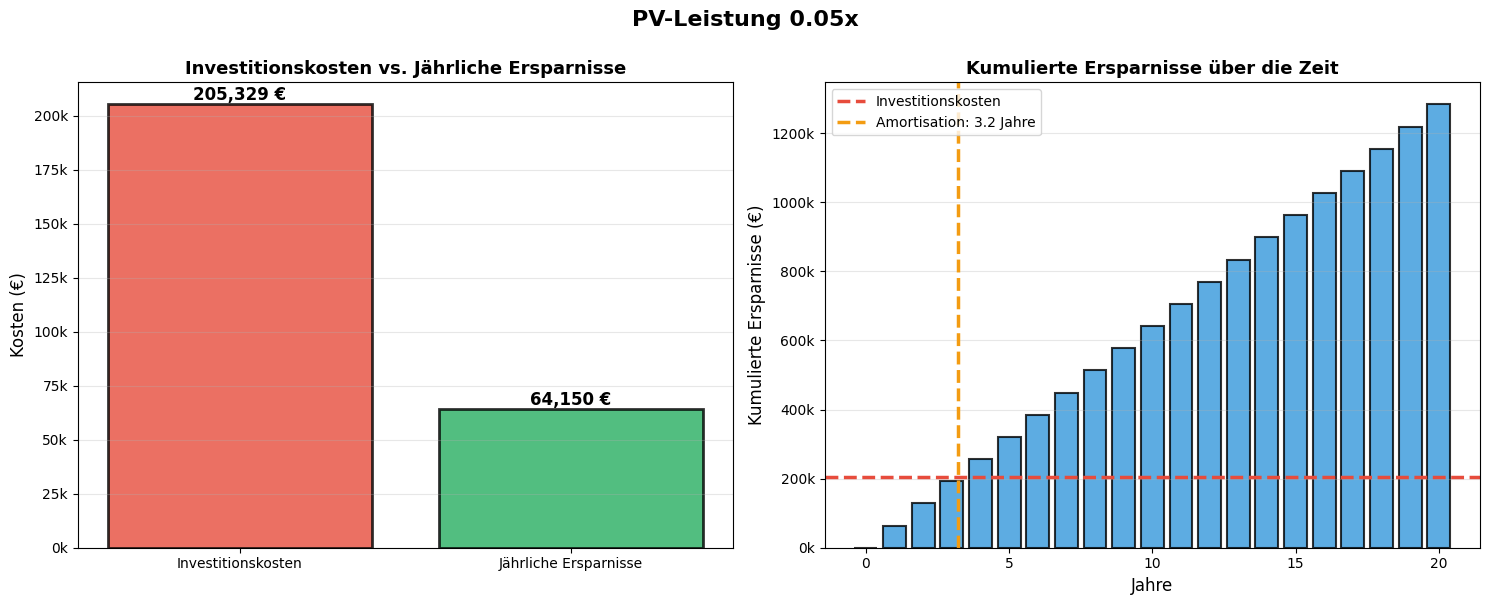


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 0.05X
Gesamtinvestitionen:                205,329 €
Jährliche Ersparnisse:               64,150 €
Amortisationszeit:                     3.20 Jahre
Ersparnisse nach 10 Jahren:         641,498 €
Ersparnisse nach 20 Jahren:       1,282,997 €


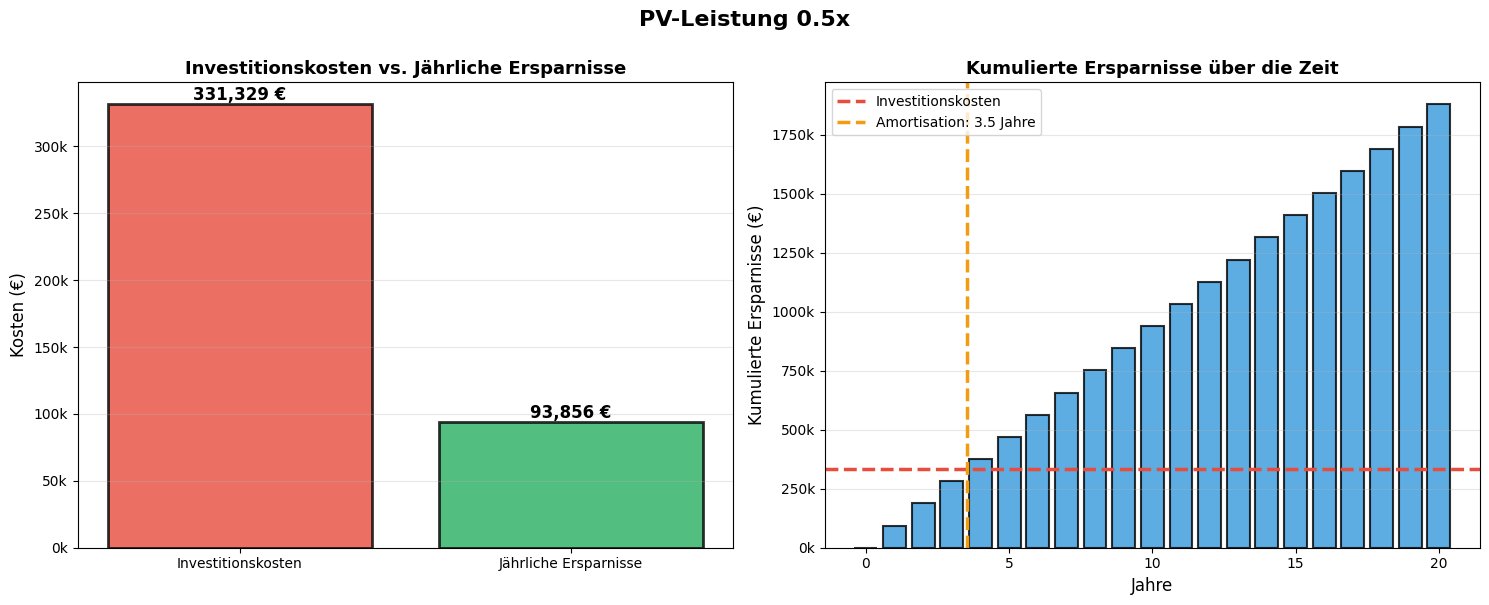


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 0.5X
Gesamtinvestitionen:                331,329 €
Jährliche Ersparnisse:               93,856 €
Amortisationszeit:                     3.53 Jahre
Ersparnisse nach 10 Jahren:         938,559 €
Ersparnisse nach 20 Jahren:       1,877,118 €


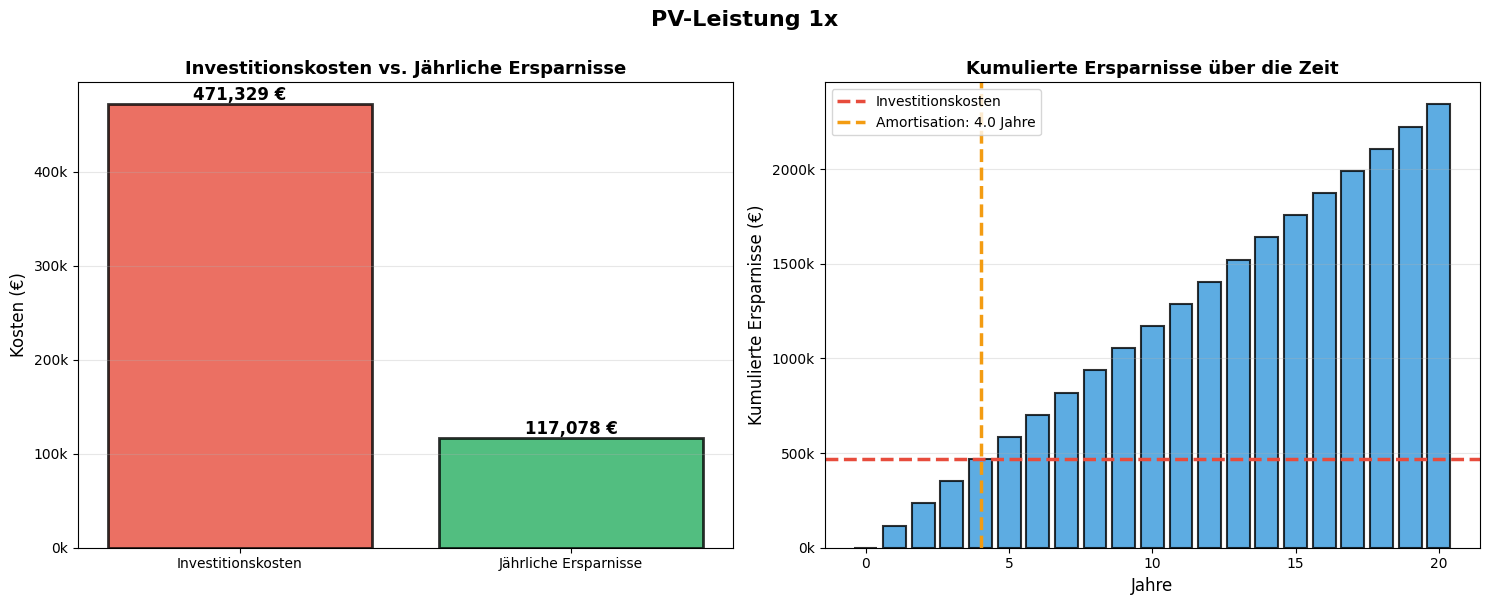


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 1X
Gesamtinvestitionen:                471,329 €
Jährliche Ersparnisse:              117,078 €
Amortisationszeit:                     4.03 Jahre
Ersparnisse nach 10 Jahren:       1,170,781 €
Ersparnisse nach 20 Jahren:       2,341,562 €


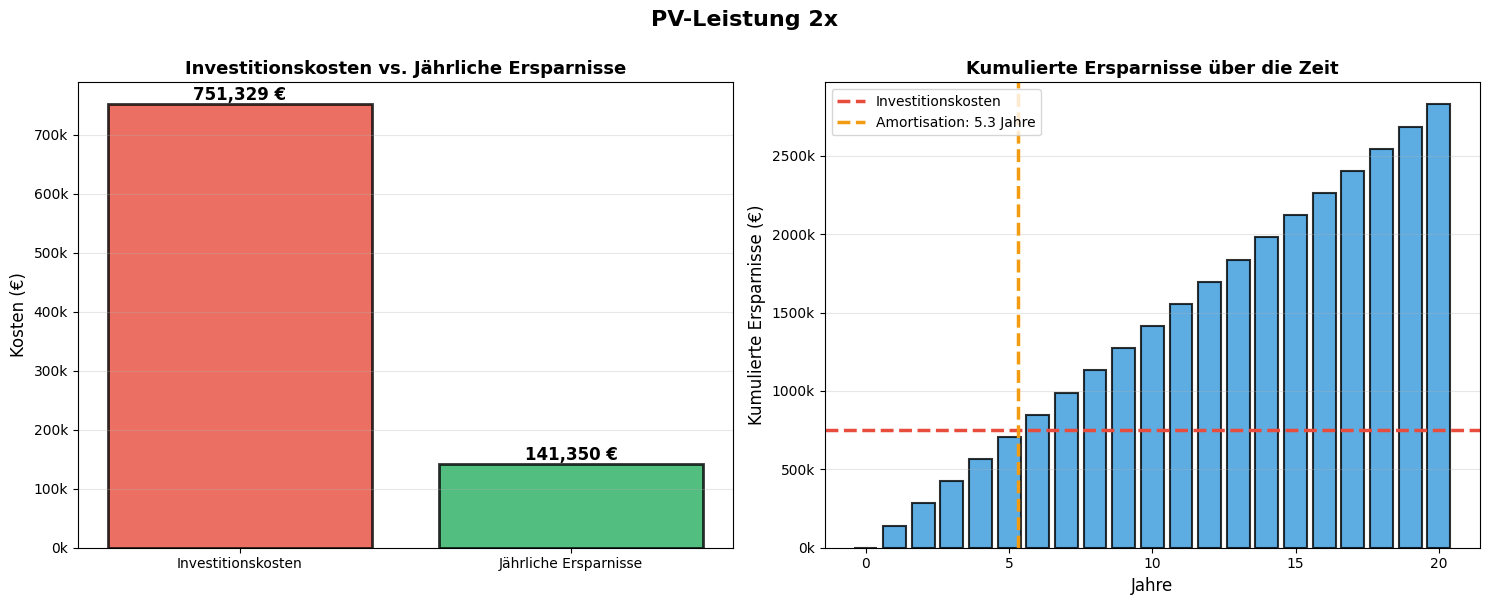


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 2X
Gesamtinvestitionen:                751,329 €
Jährliche Ersparnisse:              141,350 €
Amortisationszeit:                     5.32 Jahre
Ersparnisse nach 10 Jahren:       1,413,495 €
Ersparnisse nach 20 Jahren:       2,826,990 €


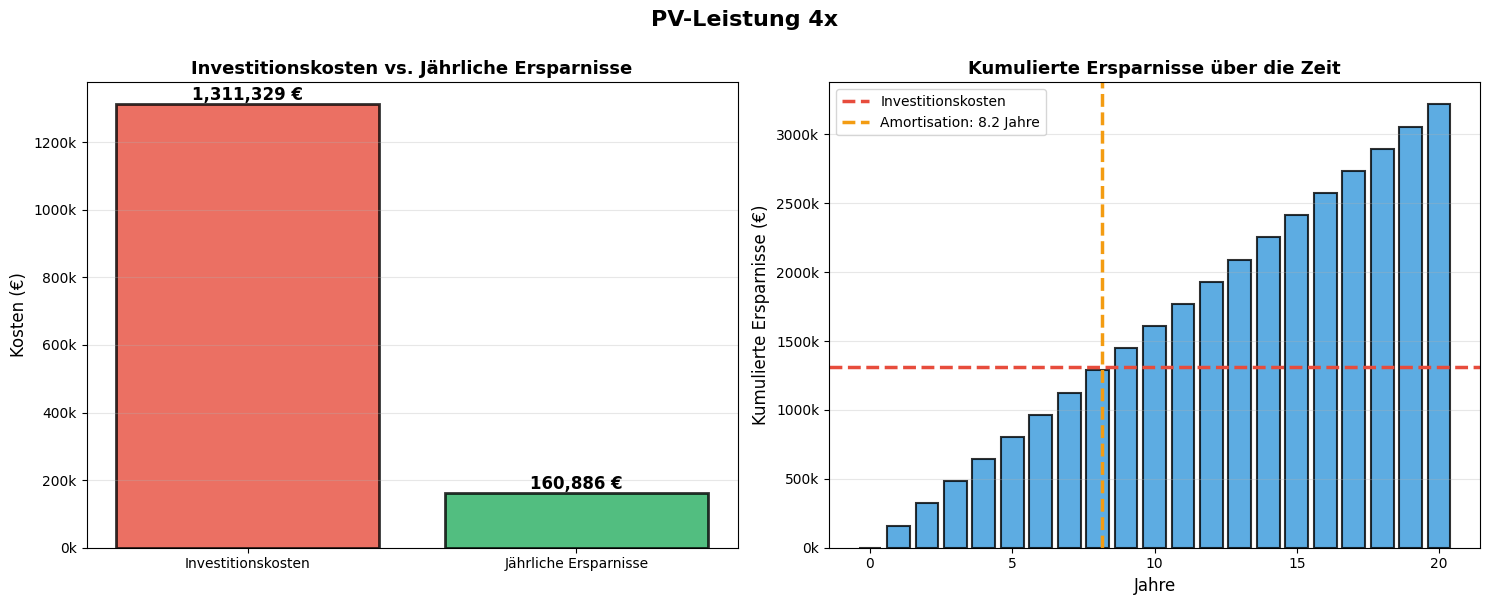


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 4X
Gesamtinvestitionen:              1,311,329 €
Jährliche Ersparnisse:              160,886 €
Amortisationszeit:                     8.15 Jahre
Ersparnisse nach 10 Jahren:       1,608,859 €
Ersparnisse nach 20 Jahren:       3,217,718 €


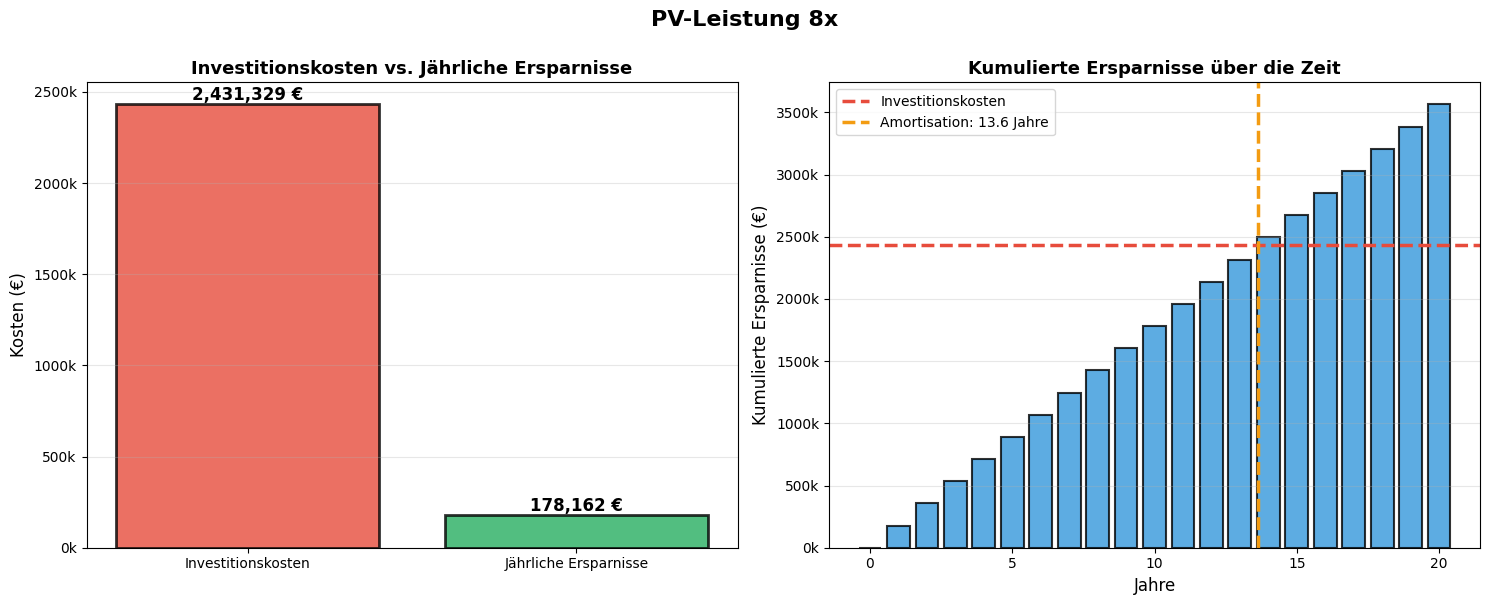


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 8X
Gesamtinvestitionen:              2,431,329 €
Jährliche Ersparnisse:              178,162 €
Amortisationszeit:                    13.65 Jahre
Ersparnisse nach 10 Jahren:       1,781,624 €
Ersparnisse nach 20 Jahren:       3,563,247 €


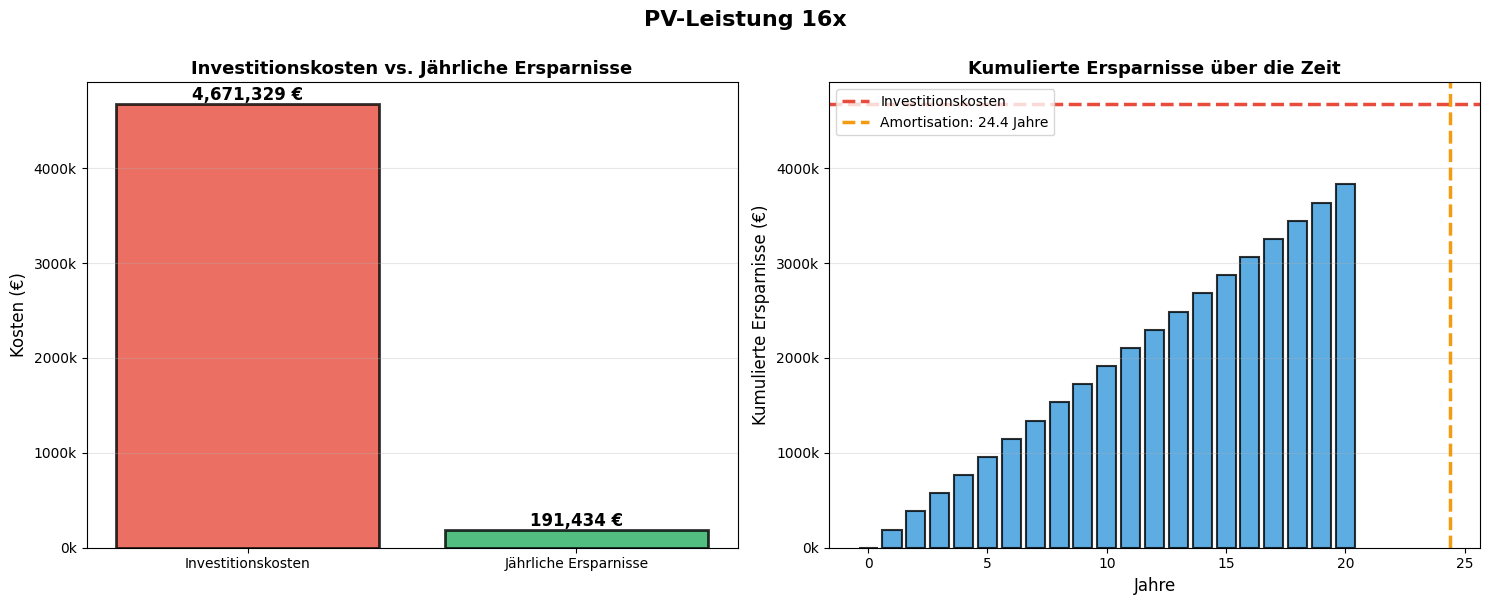


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 16X
Gesamtinvestitionen:              4,671,329 €
Jährliche Ersparnisse:              191,434 €
Amortisationszeit:                    24.40 Jahre
Ersparnisse nach 10 Jahren:       1,914,338 €
Ersparnisse nach 20 Jahren:       3,828,677 €


In [ ]:
# Vergleich: Investitionskosten vs. Ersparnisse für ALLE PV-Szenarien

# Schleife durch alle Spalten (PV-Szenarien)
for col in df_results.columns:
    # Daten für aktuelles Szenario extrahieren
    total_investment_costs_plot = df_results.loc['Gesamtinvestition (€)', col]
    annual_savings_plot = df_results.loc['Jährliche Kosteneinsparung (€)', col]
    
    # Erstelle das Balkendiagramm
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'{col}', fontsize=16, fontweight='bold', y=1.00)
    
    # Diagramm 1: Investitionskosten vs. jährliche Ersparnisse
    categories = ['Investitionskosten', 'Jährliche Ersparnisse']
    values = [total_investment_costs_plot, annual_savings_plot]
    colors = ['#E74C3C', '#27AE60']
    
    bars1 = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Werte auf den Balken anzeigen
    for bar, value in zip(bars1, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{value:,.0f} €',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax1.set_ylabel('Kosten (€)', fontsize=12)
    ax1.set_title('Investitionskosten vs. Jährliche Ersparnisse', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))
    
    # Diagramm 2: Kumulierte Ersparnisse über Jahre
    years = np.arange(0, 21)
    cumulative_savings = years * annual_savings_plot
    payback_year = total_investment_costs_plot / annual_savings_plot if annual_savings_plot > 0 else 0
    
    ax2.bar(years, cumulative_savings, color='#3498DB', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.axhline(y=total_investment_costs_plot, color='#E74C3C', linestyle='--', linewidth=2.5, label='Investitionskosten')
    ax2.axvline(x=payback_year, color='#F39C12', linestyle='--', linewidth=2.5, label=f'Amortisation: {payback_year:.1f} Jahre')
    
    ax2.set_xlabel('Jahre', fontsize=12)
    ax2.set_ylabel('Kumulierte Ersparnisse (€)', fontsize=12)
    ax2.set_title('Kumulierte Ersparnisse über die Zeit', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.legend(fontsize=10, loc='upper left')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))
    
    plt.tight_layout()
    plt.show()
    
    # Zusammenfassung für aktuelles Szenario
    print("\n" + "="*70)
    print(f"WIRTSCHAFTLICHKEITSANALYSE - {col.upper()}")
    print("="*70)
    print(f"Gesamtinvestitionen:           {total_investment_costs_plot:>12,.0f} €")
    print(f"Jährliche Ersparnisse:         {annual_savings_plot:>12,.0f} €")
    print(f"Amortisationszeit:             {payback_year:>12.2f} Jahre")
    print(f"Ersparnisse nach 10 Jahren:    {10 * annual_savings_plot:>12,.0f} €")
    print(f"Ersparnisse nach 20 Jahren:    {20 * annual_savings_plot:>12,.0f} €")
    print("="*70)

In [ ]:
# Vergleich: Investitionskosten vs. Ersparnisse

# Investitionskosten (bereits berechnet)
total_investment_costs_plot = df_results.loc['Gesamtinvestition (€)', 'PV-Leistung 1x']  # Baseline PV-Leistung (1x)

# Jährliche Ersparnisse (bereits berechnet)
annual_savings_plot = df_results.loc['Jährliche Kosteneinsparung (€)', 'PV-Leistung 1x']  # Baseline PV-Leistung (1x)

# Erstelle das Balkendiagramm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Diagramm 1: Investitionskosten vs. jährliche Ersparnisse
categories = ['Investitionskosten', 'Jährliche Ersparnisse']
values = [total_investment_costs_plot, annual_savings_plot]
colors = ['#E74C3C', '#27AE60']

bars1 = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Werte auf den Balken anzeigen
for bar, value in zip(bars1, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:,.0f} €',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Kosten (€)', fontsize=12)
ax1.set_title('Investitionskosten vs. Jährliche Ersparnisse', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

# Diagramm 2: Kumulierte Ersparnisse über Jahre
years = np.arange(0, 21)
cumulative_savings = years * annual_savings_plot
payback_year = total_investment_costs_plot / annual_savings_plot if annual_savings_plot > 0 else 0

ax2.bar(years, cumulative_savings, color='#3498DB', alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=total_investment_costs_plot, color='#E74C3C', linestyle='--', linewidth=2.5, label='Investitionskosten')
ax2.axvline(x=payback_year, color='#F39C12', linestyle='--', linewidth=2.5, label=f'Amortisation: {payback_year:.1f} Jahre')

ax2.set_xlabel('Jahre', fontsize=12)
ax2.set_ylabel('Kumulierte Ersparnisse (€)', fontsize=12)
ax2.set_title('Kumulierte Ersparnisse über die Zeit', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=10, loc='upper left')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

# Zusammenfassung
print("\n" + "="*70)
print("WIRTSCHAFTLICHKEITSANALYSE - ZUSAMMENFASSUNG")
print("="*70)
print(f"Gesamtinvestitionen:           {total_investment_costs_plot:>12,.0f} €")
print(f"Jährliche Ersparnisse:         {annual_savings_plot:>12,.0f} €")
print(f"Amortisationszeit:             {payback_year:>12.2f} Jahre")
print(f"Ersparnisse nach 10 Jahren:    {10 * annual_savings_plot:>12,.0f} €")
print(f"Ersparnisse nach 20 Jahren:    {20 * annual_savings_plot:>12,.0f} €")
print("="*70)

In [ ]:
# Amortisationszeit der Pv & Wärmepumpe & Speicher

# Speicher-Investitionskosten
battery_capacity = with_battery.stores.at["Battery", "e_nom_opt"]  # MWh
battery_cost = with_battery.stores.at["Battery", "capital_cost"]  # €/MWh
battery_investment = battery_capacity * battery_cost

thermal_storage_capacity = with_battery.stores.at["Thermal_Storage", "e_nom_opt"] *1000
thermal_storage_cost = with_battery.stores.at["Thermal_Storage", "capital_cost"]
thermal_storage_investment = thermal_storage_capacity * thermal_storage_cost

dhw_storage_capacity = with_battery.stores.at["DHW_Storage", "e_nom_opt"] * 1000
dhw_storage_cost = with_battery.stores.at["DHW_Storage", "capital_cost"]
dhw_storage_investment = dhw_storage_capacity * dhw_storage_cost

h_pump_capacity = with_battery.links.at["h_pump", "p_nom_opt"]
h_pump2_capacity = with_battery.links.at["h_pump2", "p_nom_opt"] 
h_pump_capacity_mw = h_pump_capacity + h_pump2_capacity 
investment_costs_h_pumps = h_pump_capacity_mw * capital_cost_wärmepumpe
investment_costs_pv = inhouse_pv * capital_cost_pv
total_investment_costs = investment_costs_h_pumps + investment_costs_pv + battery_investment + thermal_storage_investment + dhw_storage_investment
print(f"Investitionskosten Wärmepumpen: {investment_costs_h_pumps:.2f} €")
print(f"Investitionskosten PV-Anlage: {investment_costs_pv:.2f} €")
print(f"Investitionskosten Batterie: {battery_investment:.2f} €")
print(f"Investitionskosten Thermalspeicher: {thermal_storage_investment:.2f} €")
print(f"Investitionskosten DHW-Speicher: {dhw_storage_investment:.2f} €")
print(f"Gesamte Investitionskosten: {total_investment_costs:.2f} €")

# Stromverbrauch der Wärmepumpen (elektrische Energie rein)
h_pump_electricity = with_battery.links_t.p0["h_pump"].sum()  # MWh (Strom)
h_pump2_electricity = with_battery.links_t.p0["h_pump2"].sum()  # MWh (Strom)
total_hp_electricity = h_pump_electricity + h_pump2_electricity
print(total_hp_electricity)

# Wärmeerzeugung der Wärmepumpen (thermische Energie raus)
h_pump_heat = with_battery.links_t.p1["h_pump"].sum()  # MWh (Wärme)
h_pump2_heat = with_battery.links_t.p1["h_pump2"].sum()  # MWh (Wärme)
total_hp_heat = h_pump_heat + h_pump2_heat
print(total_hp_heat)

electricity_saved_with__pump = (total_hp_heat+total_hp_electricity)*-1
electricity_saved_with_pv = with_battery.generators_t.p["PV"].sum()  # MWh (direkt von PV genutzt)
print(f"Elektrizitätsersparnis durch Wärmepumpen: {electricity_saved_with__pump:.2f} MWh")
print(f"Elektrizitätsersparnis durch PV-Anlage: {electricity_saved_with_pv:.2f} MWh")

total_electricity_saved = electricity_saved_with__pump + electricity_saved_with_pv
print(f"Gesamte Elektrizitätsersparnis: {total_electricity_saved:.2f} MWh")

annual_savings = total_electricity_saved * stromkosten
print(f"Jährliche Kosteneinsparung: {annual_savings:.2f} €")
amortization_time = total_investment_costs / annual_savings
print(f"Amortisationszeit: {amortization_time:.2f} Jahre")

Investitionskosten Wärmepumpen: 65491.38 €
Investitionskosten PV-Anlage: 280000.00 €
Investitionskosten Batterie: -0.00 €
Investitionskosten Thermalspeicher: 67314.18 €
Investitionskosten DHW-Speicher: 58523.77 €
Gesamte Investitionskosten: 471329.33 €
137.13394729427992
-541.893887022276
Elektrizitätsersparnis durch Wärmepumpen: 404.76 MWh
Elektrizitätsersparnis durch PV-Anlage: 871.47 MWh
Gesamte Elektrizitätsersparnis: 1276.23 MWh
Jährliche Kosteneinsparung: 191433.84 €
Amortisationszeit: 2.46 Jahre


In [ ]:
# Investitionskosten berechnen

# Speicher-Investitionskosten
battery_capacity = with_battery.stores.at["Battery", "e_nom_opt"]  # MWh
battery_cost = with_battery.stores.at["Battery", "capital_cost"]  # €/MWh
battery_investment = battery_capacity * battery_cost

thermal_storage_capacity = with_battery.stores.at["Thermal_Storage", "e_nom_opt"]
thermal_storage_cost = with_battery.stores.at["Thermal_Storage", "capital_cost"]
thermal_storage_investment = thermal_storage_capacity * thermal_storage_cost

dhw_storage_capacity = with_battery.stores.at["DHW_Storage", "e_nom_opt"]
dhw_storage_cost = with_battery.stores.at["DHW_Storage", "capital_cost"]
dhw_storage_investment = dhw_storage_capacity * dhw_storage_cost

# Wärmepumpen-Investitionskosten (falls Sie capital_cost hinzufügen)
h_pump_capacity = with_battery.links.at["h_pump", "p_nom_opt"]  # MW
h_pump2_capacity = with_battery.links.at["h_pump2", "p_nom_opt"]  # MW
# Beispiel: 500.000 €/MW für Wärmepumpen (Sie müssen den realen Wert einsetzen)
h_pump_cost = 500000  # €/MW
h_pump_investment = (h_pump_capacity + h_pump2_capacity) * h_pump_cost

# Gesamte Investitionskosten
total_investment = (battery_investment + thermal_storage_investment + 
                   dhw_storage_investment + h_pump_investment)

print("=" * 50)
print("INVESTITIONSKOSTEN")
print("=" * 50)
print(f"Batteriespeicher: {battery_investment:,.2f} €")
print(f"Wärmespeicher (Heizung): {thermal_storage_investment:,.2f} €")
print(f"Warmwasserspeicher: {dhw_storage_investment:,.2f} €")
print(f"Wärmepumpen: {h_pump_investment:,.2f} €")
print("=" * 50)
print(f"GESAMT: {total_investment:,.2f} €")
print("=" * 50)

INVESTITIONSKOSTEN
Batteriespeicher: -0.00 €
Wärmespeicher (Heizung): 67.31 €
Warmwasserspeicher: 58.52 €
Wärmepumpen: 32,745.69 €
GESAMT: 32,871.53 €


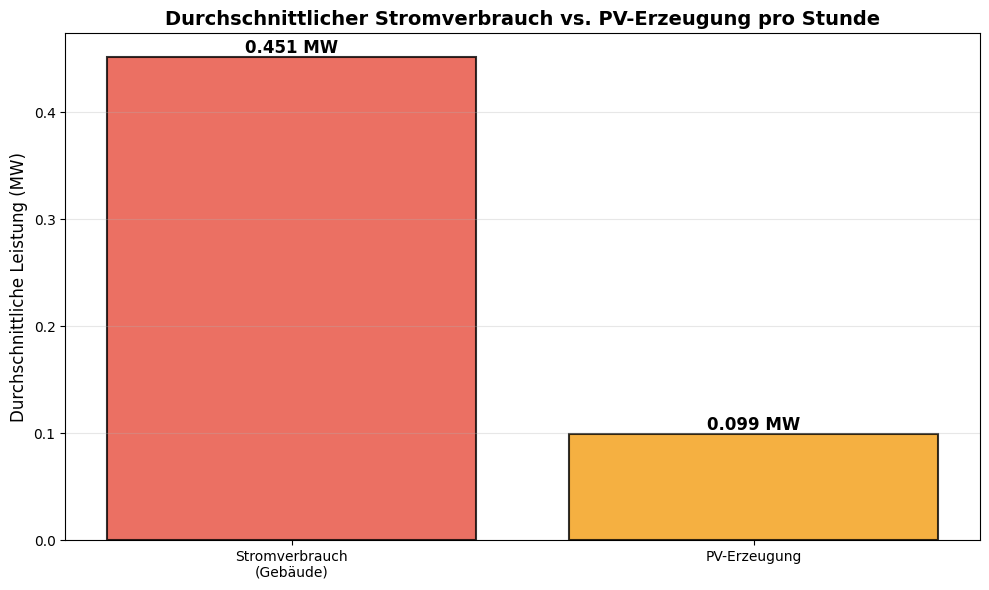

In [54]:
# Balkendiagramm: Durchschnittlicher Stromverbrauch vs. PV-Erzeugung
avg_building_load = total_electricity_demand / 8760
avg_pv_generation = pv_energy / 8760

plt.figure(figsize=(10, 6))
categories = ['Stromverbrauch\n(Gebäude)', 'PV-Erzeugung']
values = [avg_building_load, avg_pv_generation]
colors = ['#E74C3C', '#F39C12']

bars = plt.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Werte auf den Balken anzeigen
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f} MW',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Durchschnittliche Leistung (MW)', fontsize=12)
plt.title('Durchschnittlicher Stromverbrauch vs. PV-Erzeugung pro Stunde', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

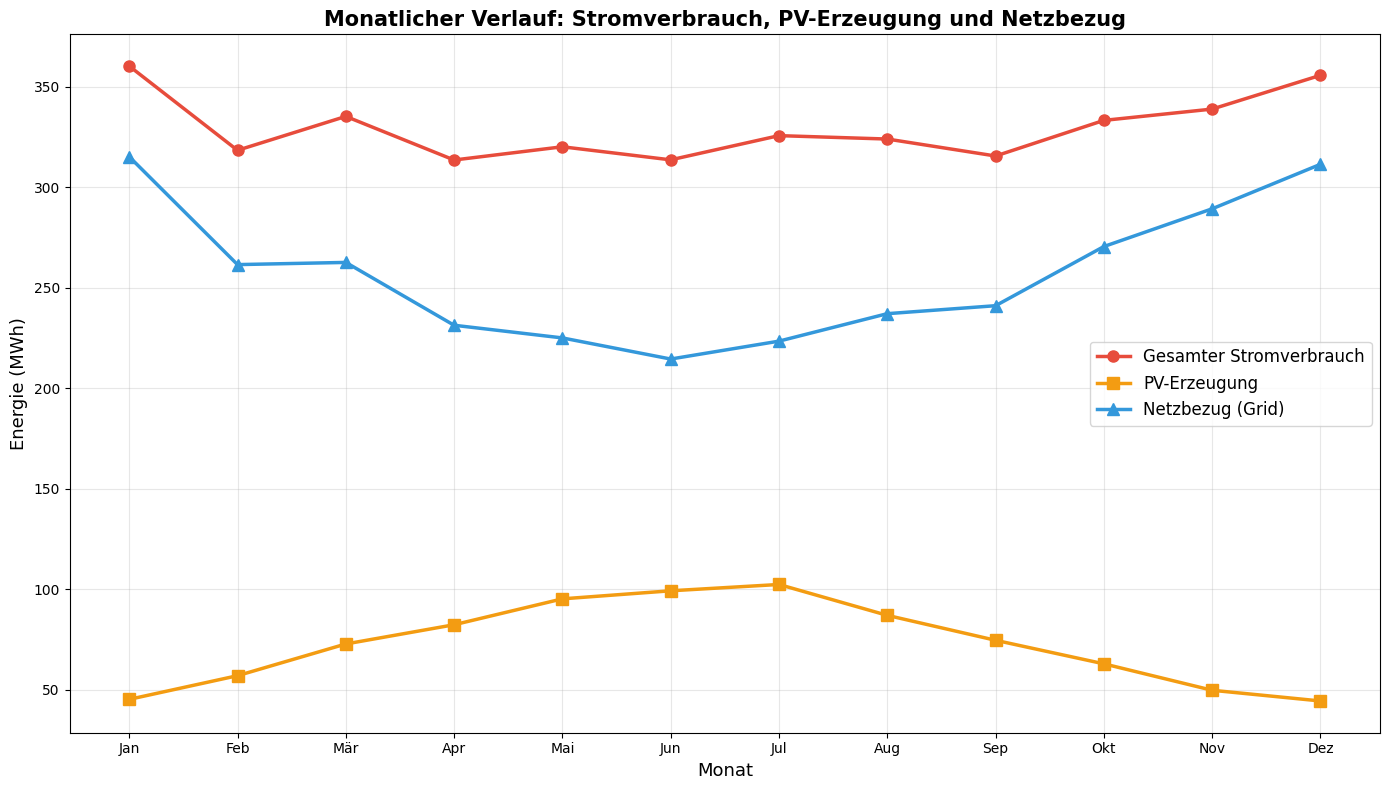

In [55]:
# Plot: Monatlicher Verlauf von Stromverbrauch, Grid-Bezug und PV-Erzeugung
plt.figure(figsize=(14, 8))

# Gesamter Stromverbrauch (direkt + Wärmepumpen)
total_load = (with_battery.loads_t.p["building_load"] + 
              with_battery.loads_t.p["fleet_load"] + 
              with_battery.links_t.p0["h_pump"] + 
              with_battery.links_t.p0["h_pump2"]).values

# PV-Erzeugung
pv_generation = with_battery.generators_t.p["PV"].values

# Grid-Bezug
grid_power = with_battery.generators_t.p["Grid"].values

# Umwandlung in monatliche Summen (MWh)
hours_per_month = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]  # Stunden pro Monat
months = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']

monthly_load = []
monthly_pv = []
monthly_grid = []

start_hour = 0
for hours in hours_per_month:
    end_hour = start_hour + hours
    monthly_load.append(total_load[start_hour:end_hour].sum())
    monthly_pv.append(pv_generation[start_hour:end_hour].sum())
    monthly_grid.append(grid_power[start_hour:end_hour].sum())
    start_hour = end_hour

# Plots
plt.plot(months, monthly_load, label='Gesamter Stromverbrauch', linewidth=2.5, color='#E74C3C', marker='o', markersize=8)
plt.plot(months, monthly_pv, label='PV-Erzeugung', linewidth=2.5, color='#F39C12', marker='s', markersize=8)
plt.plot(months, monthly_grid, label='Netzbezug (Grid)', linewidth=2.5, color='#3498DB', marker='^', markersize=8)

plt.xlabel('Monat', fontsize=13)
plt.ylabel('Energie (MWh)', fontsize=13)
plt.title('Monatlicher Verlauf: Stromverbrauch, PV-Erzeugung und Netzbezug', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()